In [1]:
%pip install torch torchvision torchaudio
%pip install matplotlib

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# reading all the names
words = open("names.txt", "r").read().splitlines()
# words[:8]

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]  #crop and append 


X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# build the dataset 

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  #crop and append 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])                   #80%
Xdev, Ydev = build_dataset(words[n1:n2])               #10%
Xte, Yte = build_dataset(words[n2:])                   #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [8]:
# --------------------------Making it more compact-------------

In [47]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),                 generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),     generator=g)
b1 = torch.randn(n_hidden,                            generator=g)
W2 = torch.randn((n_hidden, vocab_size),              generator=g) * 0
b2 = torch.randn(vocab_size,                          generator=g) * 0.01
parameters = [C, W1, b1, W2, b2]


In [10]:
sum(p.nelement() for p in parameters)  # number of parameter in total

11897

In [48]:
for p in parameters:
    p.requires_grad = True

In [49]:
# optimization 
max_steps = 200000
batch_size = 32
lri = []
lossi = []
stepi = []


In [50]:
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]            # batch X, Y

    # forward pass
    emb = C[Xb] #(32, 3, 2)               # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)   # concatenate the vectors
    hpreact = embcat @ W1 + b1            #hidden layer pre-activation
    h = torch.tanh(hpreact)               #hidden layer
    logits = h @ W2 + b2  # (32, 27)      #output layer
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i] 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # stepi.append(i)

    if i % 10000 == 0:# print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())

    break


# print(loss.item())


      0/ 200000: 3.2953


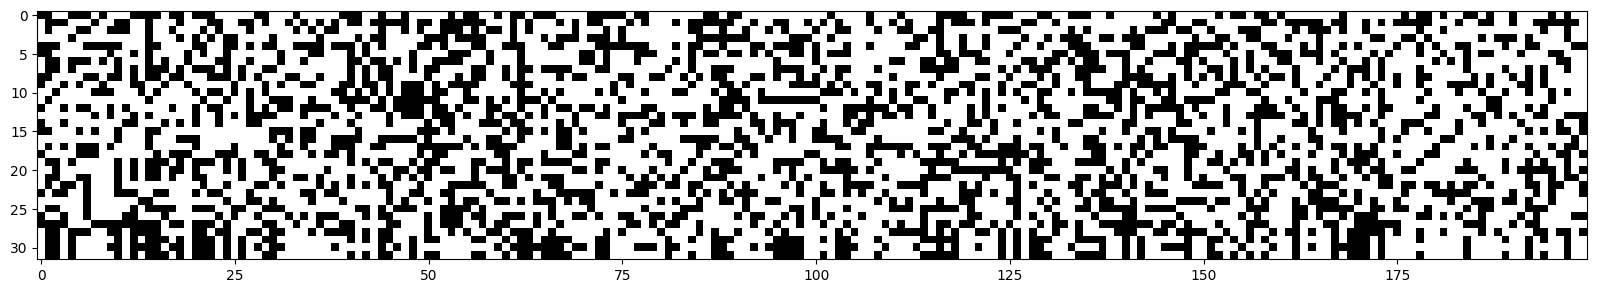

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')

(array([2069.,  144.,  106.,   82.,   59.,   56.,   43.,   31.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

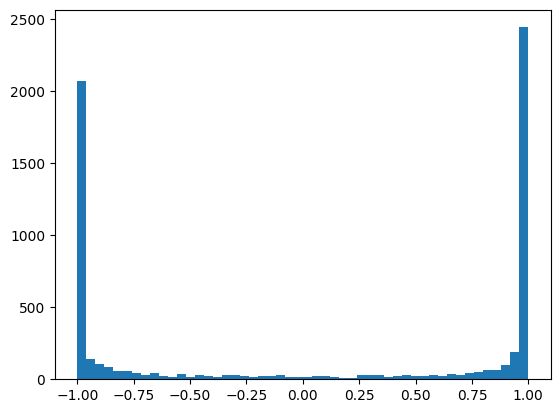

In [52]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793762, -18.31571915, -17.57350067, -16.8312822 ,
        -16.08906372, -15.34684525, -14.60462677, -13.86240829,
        -13.12018982, -12.37797134, -11.63575287, -10.89353439,
        -10.15131592,  -9.40909744,  -8.66687897,  -7.92466049,
         -7.18244202,  -6.44022354,  -5.69800507,  -4.95578659,
         -4.21356812,  -3.47134964,  -2.72913116,  -1.98691269,
         -1.24469421,  -0.50247574,   0.23974274,   0.98196121,
          1.72417969,   2.46639816,   3.20861664,   3.95083511,
          4.69305359,   5.43527206,   6.17749054,   6.91970901,
          7.66192749,   8.40414597,   9.14636444,   9.88858292,
         10.630801

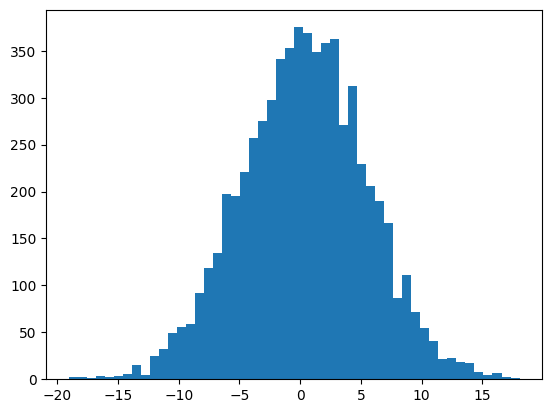

In [53]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [25]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

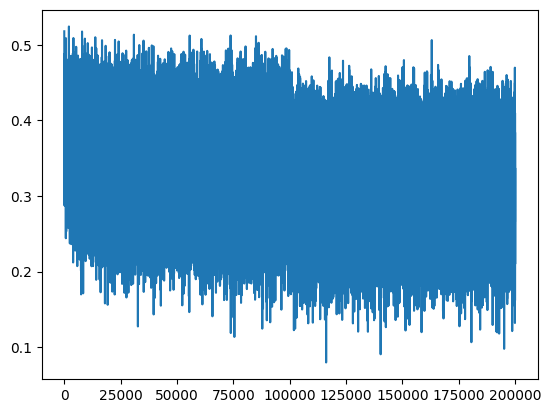

In [44]:
plt.plot(lossi)

In [45]:
@torch.no_grad() # more efficient disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte), 
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)   # concatenate the vectors
    hpreact = embcat @ W1 + b1            #hidden layer pre-activation
    h = torch.tanh(hpreact)               #hidden layer
    logits = h @ W2 + b2  # (32, 27)      #output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.069460868835449
val 2.130242347717285


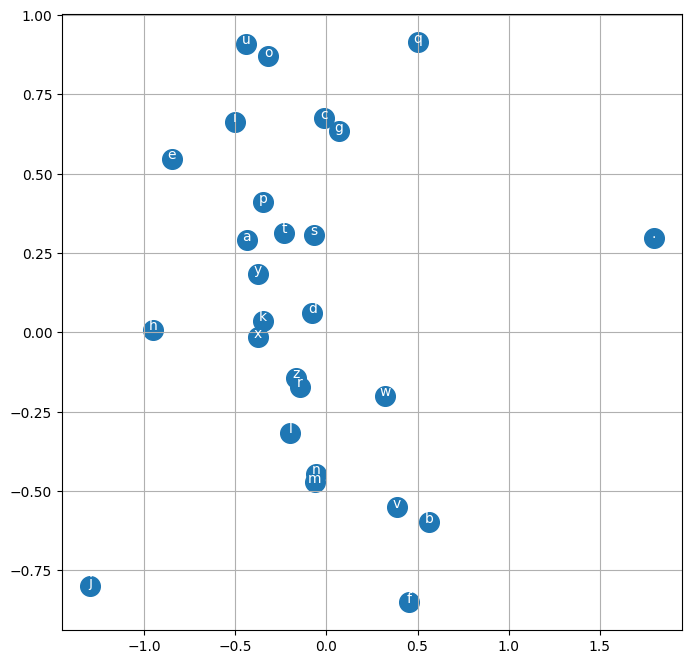

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", color="white")
plt.grid('minor')

In [46]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carman.
amille.
khyimlli.
taty.
sacaysie.
mahnel.
deliah.
jareen.
nellara.
chaiivia.
legend.
bron.
cadeenan.
salin.
alianni.
waverly.
jarysi.
jaxeenissa.
mel.
edi.
